In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib


In [13]:
df = pd.read_csv("data/CAvideos_cc50_202101_cleaned.csv")

In [14]:
# Variables independientes
features = ['views', 'likes', 'dislikes', 'comment_count',
            'engagement_rate', 'days_until_trending', 'like_ratio']

# Variable objetivo
target = 'is_viral'

# Matrices X e y
X = df[features]
y = df[target]

In [15]:
# División 70% entrenamiento - 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (16420, 7)
X_test: (7038, 7)


In [16]:
# Estandarizar variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar tensores y el scaler
joblib.dump(X_train_scaled, "./data/X_train_scaled.pkl")
joblib.dump(X_test_scaled, "./data/X_test_scaled.pkl")
joblib.dump(y_train, "./data/y_train.pkl")
joblib.dump(y_test, "./data/y_test.pkl")
joblib.dump(scaler, "./data/scaler.pkl")

print("Tensores guardados correctamente.")


Tensores guardados correctamente.


In [17]:
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
)

In [19]:
X_train = joblib.load("./data/X_train_scaled.pkl")
X_test = joblib.load("./data/X_test_scaled.pkl")
y_train = joblib.load("./data/y_train.pkl")
y_test = joblib.load("./data/y_test.pkl")

In [20]:
# Funcion auxiliar para evaluar modelos
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    print("F1:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))


In [ ]:
# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)
log_reg.fit(X_train, y_train)

evaluate_model(log_reg, X_test, y_test, "Logistic Regression")


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.7567    0.7793    0.7679      3856
           1     0.7225    0.6964    0.7092      3182

    accuracy                         0.7418      7038
   macro avg     0.7396    0.7379    0.7385      7038
weighted avg     0.7413    0.7418    0.7414      7038

Confusion Matrix:
 [[3005  851]
 [ 966 2216]]
AUC: 0.8408983624172276
F1: 0.709233477356377
Precision: 0.7225301597652429
Recall: 0.6964173475801383


In [22]:
# Ramdom Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)
rf.fit(X_train, y_train)

evaluate_model(rf, X_test, y_test, "Random Forest")


=== Random Forest ===
              precision    recall  f1-score   support

           0     1.0000    0.9984    0.9992      3856
           1     0.9981    1.0000    0.9991      3182

    accuracy                         0.9991      7038
   macro avg     0.9991    0.9992    0.9991      7038
weighted avg     0.9991    0.9991    0.9991      7038

Confusion Matrix:
 [[3850    6]
 [   0 3182]]
AUC: 0.9999977994736994
F1: 0.9990580847723705
Precision: 0.9981179422835633
Recall: 1.0


In [ ]:
# XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)
xgb.fit(X_train, y_train)

evaluate_model(xgb, X_test, y_test, "XGBoost")


=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9995    0.9992    0.9994      3856
           1     0.9991    0.9994    0.9992      3182

    accuracy                         0.9993      7038
   macro avg     0.9993    0.9993    0.9993      7038
weighted avg     0.9993    0.9993    0.9993      7038

Confusion Matrix:
 [[3853    3]
 [   2 3180]]
AUC: 0.9999976364717511
F1: 0.9992144540455616
Precision: 0.9990574929311969
Recall: 0.9993714644877436


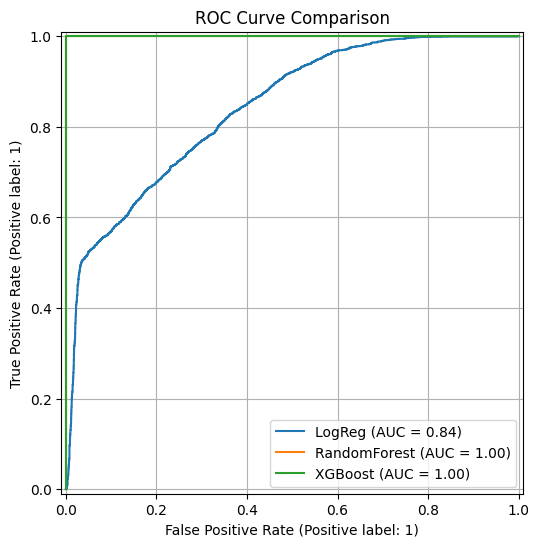

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(log_reg, X_test, y_test, name="LogReg", ax=ax)
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="RandomForest", ax=ax)
RocCurveDisplay.from_estimator(xgb, X_test, y_test, name="XGBoost", ax=ax)
plt.title("ROC Curve Comparison")
plt.grid(True)
plt.show()